Start

In [72]:
#using MorporJ
include("../src/MorporJ.jl")
using LinearAlgebra
using Test
using Plots
#using Surrogates
using Interpolations
using HDF5
using PyCall
@pyimport h5py


Import snapshots

In [2]:
fid = h5open("../snapshots/data_snapshots_onlymu_nomu1.h5", "r")
A=[]
exponent=2
mu_ratio=[10,20,30,40,50,60,70,80,90,100]
#dset=zeros(size(mu_ratio,1),size(exponent,1));
for j=1:size(mu_ratio,1)
#     for i=1:size(exponent,1)
        g=read(fid, "snap_mu_$(mu_ratio[j])")
        dset = g["snap_exp_$(exponent)"]
        push!(A,dset')
#     end
end
S=hcat([A[i] for i in 1:length(A)]...)
Nx=size(S,1)
Ns=size(S,2)
println(size(S))
close(fid)

(1000, 500)


In [3]:
close(fid)

Import final time

In [4]:
f2 = h5py.File("../snapshots/data_snapshots_onlymu_nomu1.h5", "r")
group2 = f2.get("snap_mu_10")
dataset2=group2.get("snap_exp_2")
print(dataset2.attrs.items())
tempo=zero(Int64)
for item in dataset2.attrs.items()
    print(item)
    if item[1]=="Years of simulation"
        tempo=parse(Int64, item[2])
        print(tempo)
    end
end
f2.close()

PyObject ItemsViewHDF5(<Attributes of HDF5 object at 140140680630872>)(

"Exponent of Relative Permeability Law", "2")("Horizontal Length", "0 - 1000")("Injector Pressure", "41370000")("Injector Wetting Saturation", "1")("NonWetting Viscosity", "0.03")("Number of mesh cells", "1000")("Permeability", "0")("Producer Pressure", "27580000")("Residual NonWetting Saturation", "0")("Residual Wetting Saturation", "0")("Rock Porosity", "0")("Vertical Height", "0 - 1")("Viscosities Ratio", "10")("Well Radius", "0")("Well Skin", "0")("Wetting Viscosity", "0")("Years of simulation", "5")5

In [5]:
tempo=5

5

In [6]:
S = vcat(zeros(1, size(S)[2]), S);

In [7]:
N,Nₜₚ = size(S)
nₜₚ = size(S)[2] #number of kept snapshots
M = N
param=length(exponent)*length(mu_ratio)
nₛ₁=Int(nₜₚ/param)
deltat=round(tempo/nₛ₁,digits = 2)

0.1

Compute cdf, icdf

In [8]:
xgrid = collect(range(0, 1, length = N)) 
pgrid = collect(range(0, 1, length = M))

Δx = xgrid[2] - xgrid[1]

# normalize
S₁ = zero(S)
for i in 1:nₜₚ
    m₀ = sum(S[:,i]) * Δx
    S₁[:,i] .= S[:,i] ./ m₀
end

In [9]:
s_pdf = [S₁[:,i] for i in 1:nₜₚ]
s_cdf = [zeros(N) for _ in 1:nₜₚ]
s = [zeros(M) for _ in 1:nₜₚ]

for i in eachindex(s_cdf)
    MorporJ.cdf!(s_cdf[i], S₁[:,i], Δx)
    MorporJ.icdf!(s[i], s_cdf[i], xgrid, pgrid)
end

# POD

In [10]:
U, Σ, Vᵀ = svd(S₁);

In [11]:
n_pod = 50
Ψ = U[:,1:n_pod]
sᵣ_pdf_pod = [Ψ*Ψ'*S₁[:,i] for i in 1:nₜₚ];
n_pod

50

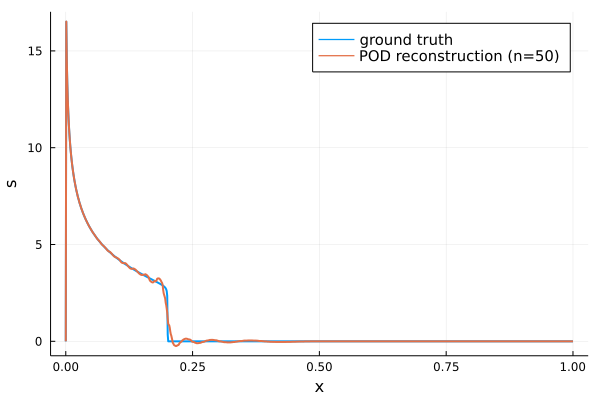

In [12]:
iₑₓ = 327
gr();
plot(xgrid, S₁[:,iₑₓ], label="ground truth",xlabel="x",ylabel="s",linewidth=2)
plot!(xgrid,sᵣ_pdf_pod[iₑₓ], label="POD reconstruction (n=$n_pod)",linewidth=2,legendfontsize=10)
#savefig("../pictures/svd_example.png")

# GREEDY

In [73]:
D=zeros(nₜₚ,nₜₚ)
for i in 1:nₜₚ
    for j in 1:nₜₚ
        D[i,j]=norm(s[i]-s[j],2)
    end
end
argmax(D)
maxD=Tuple(argmax(D))
minD=Tuple(argmin(D))
a = [s[maxD[2]], s[maxD[1]]];
basis_index = [maxD[2], maxD[1]]
n = length(a)
a_0 = copy(a);

In [74]:
Λ, ΔW, ΔW_max, a, basis_index = MorporJ.greedy_algo!(s, a_0, Δx, basis_index; rtol=5e-1, tol=1e-5, max_iter_solver=100000);

Current W2 error: 0.004410765009234422 with atoms: 1 500.
Adding snapshot number: 50 
Current W2 error: 7.56156190436982e-5 with atoms:

 1 500 50.
Adding snapshot number: 151 
Current W2 error: 7.933424274806545e-5 with atoms:

 1 500 50 151.
Relative tolerance not met - -0.0491779840117192. Removing last dictionary atom. 


In [76]:
n = length(a)
sᵣ = [zeros(M) for i in 1:nₜₚ]
for j in 1:nₜₚ
    for i in 1:n
        sᵣ[j] .+= Λ[end][j][i] .* a[i] # u approx
    end
end
sᵣ_cdf = [zeros(N) for i in 1:nₜₚ]
sᵣ_pdf = [zeros(N) for i in 1:nₜₚ]
sₑ_cdf = [zeros(N) for i in 1:nₜₚ]
sₑ_pdf = [zeros(N) for i in 1:nₜₚ]

for j in 1:nₜₚ
    MorporJ.iicdf!(sᵣ_cdf[j], sᵣ[j], xgrid, pgrid)
    MorporJ.iicdf!(sₑ_cdf[j], s[j], xgrid, pgrid)
    MorporJ.cdf_to_pdf!(sᵣ_pdf[j], sᵣ_cdf[j], Δx; order=1)
    MorporJ.cdf_to_pdf!(sₑ_pdf[j], sₑ_cdf[j], Δx; order=1)
end


In [77]:
ΔL1 = zero(ΔW[end])
ΔL1_recon = zero(ΔW[end])
ΔL2 = zero(ΔW[end])
ΔL∞ = zero(ΔW[end])
for i in eachindex(ΔL1)
    ΔL1[i] = norm(sᵣ_pdf[i] - S₁[:,i], 1) * Δx
    ΔL1_recon[i] = norm(sₑ_pdf[i] - S₁[:,i], 1) * Δx
    ΔL2[i] = norm(sᵣ_pdf[i] - S₁[:,i], 2) * Δx
    ΔL∞[i] = maximum(abs.(sᵣ_pdf[i] - S₁[:,i]))
end


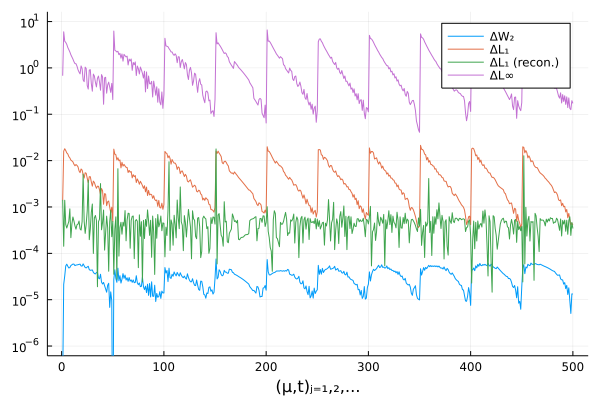

In [79]:
plot([ ΔW[end],  
        ΔL1,
        ΔL1_recon,  
        ΔL∞
        ],
        yaxis = :log, label = ["ΔW₂" "ΔL₁" "ΔL₁ (recon.)" "ΔL∞"], xlabel="(μ,t)ⱼ₌₁,₂,...", 
        legend = :topright, yticks=collect(10.0 .^(-6:1)), ylimits=[1e-6,1e1])
#savefig("../pictures/greedy_errors.png")

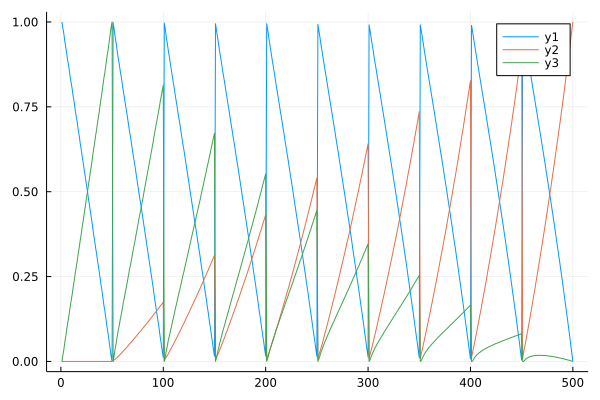

In [80]:
p = plot([Λ[end][i][1] for i in eachindex(Λ[end])] )
for j in 2:size(Λ[end][1],1)
    plot!([Λ[end][i][j] for i in eachindex(Λ[end])] )
end
p

# Interpolations

In [81]:
nodes = (collect(0.1:0.1:5), 1.0*mu_ratio);
lambda_vec_vec = [ [Λ[end][i][j] for i in eachindex(Λ[end])] for j in 1:n];
mass = zeros(nₜₚ)
for i in eachindex(mass)
    mass[i] = sum(S[:,i])*Δx
end
mass = reshape(mass, (50,10));


In [83]:
lambda_mat_vec = [zeros(50,10) for j in 1:n];

In [84]:
for i in 1:n
    lambda_mat_vec[i] = reshape(lambda_vec_vec[i], (50,10))
end

In [85]:
itp = [interpolate(nodes, lambda_mat_vec[i], Gridded(Linear())) for i in 1:n];
mass_itp = interpolate(nodes, mass, Gridded(Linear()));

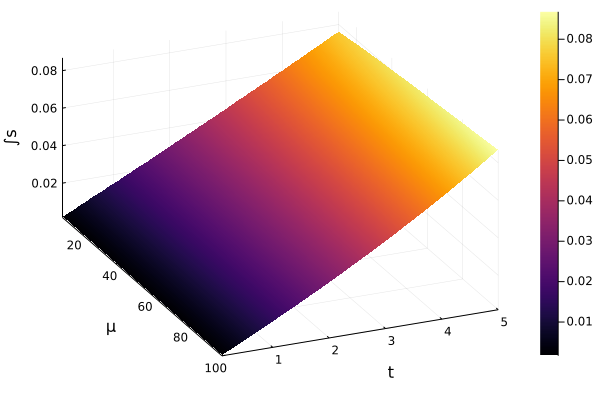

In [86]:
gr();
surface(10:1:100, 0.1:0.01:5, mass_itp(0.1:0.01:5,10:1:100), ylabel="t", xlabel="μ",zlabel="∫s",camera=(60,60))
#savefig("../pictures/mass_interp.png")


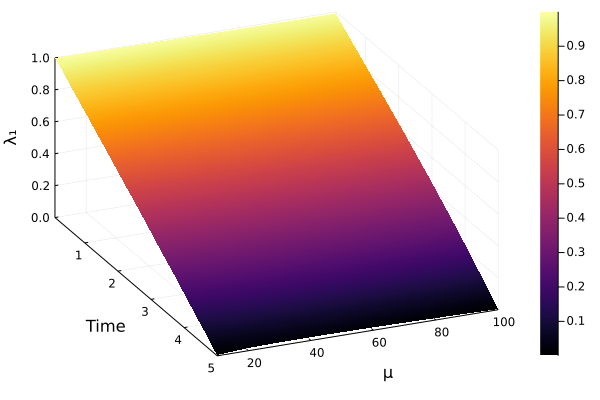

In [87]:
surface( 0.1:0.01:5, 10:1:100, itp[1](0.1:0.01:5,10:1:100)', ylabel="μ", xlabel="Time",zlabel="λ₁",zlim=[0, 1],camera=(60,60))
#savefig("../pictures/first_coeff.png")

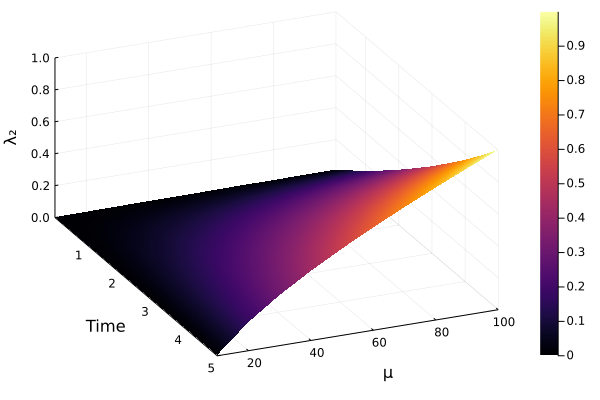

In [88]:
surface( 0.1:0.01:5, 10:1:100, itp[2](0.1:0.01:5,10:1:100)', ylabel="μ", xlabel="Time",zlabel="λ₂",zlim=[0, 1],camera=(60,60))
#savefig("../pictures/second_coeff.png")

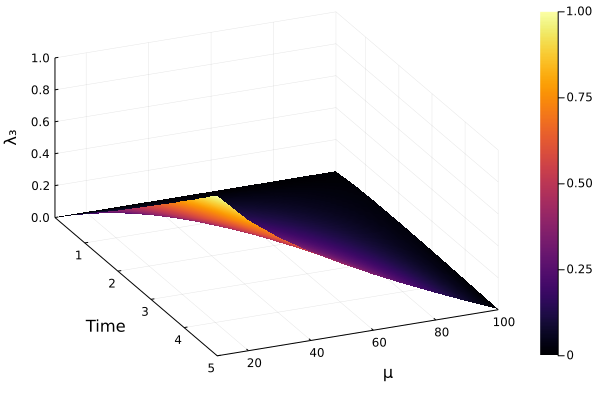

In [89]:
surface( 0.1:0.01:5, 10:1:100, itp[3](0.1:0.01:5,10:1:100)', ylabel="μ", xlabel="Time",zlabel="λ₃",zlim=[0, 1],camera=(60,60))
#savefig("../pictures/third_coeff.png")

Video snapshots

In [54]:
function reconstruct_s!(s, t, mu)
    tmp = zero(s)
    Λ_r = zeros(n)
    mass_r = mass_itp(t,mu)
    for i in 1:n
        s .+= itp[i](t,mu) .* a[i] # u approx
    end
    MorporJ.iicdf!(tmp, s, xgrid, pgrid)
    MorporJ.cdf_to_pdf!(s, tmp, Δx; order=2)
    s .*= mass_r
end

reconstruct_s! (generic function with 1 method)

In [66]:
t_recon = collect(0.1:0.1:5)
s_recon = [zeros(N) for _ in t_recon]
mu_recon = 67.5 #round( 10 + rand()*90, digits=1)
for i in eachindex(s_recon)
    reconstruct_s!(s_recon[i], t_recon[i], mu_recon)
end

μ₋ = floor(mu_recon/10 )*10
μ₊ = ceil(mu_recon/10 )*10
i₋ = 50*Int(floor(mu_recon/10)-1)
i₊ = 50*Int(ceil(mu_recon/10)-1)
#=
μ₋ = 10
μ₊ = 100
i₋ = 0
i₊ = 450  
=# 

   

300

┌ Info: Saved animation to 
│   fn = /home/tobias/Documents/IPP/CIRM/MorporJ/notebooks/s_recon.gif
└ @ Plots /home/tobias/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/home/tobias/Documents/IPP/CIRM/MorporJ/notebooks/s_recon.gif")
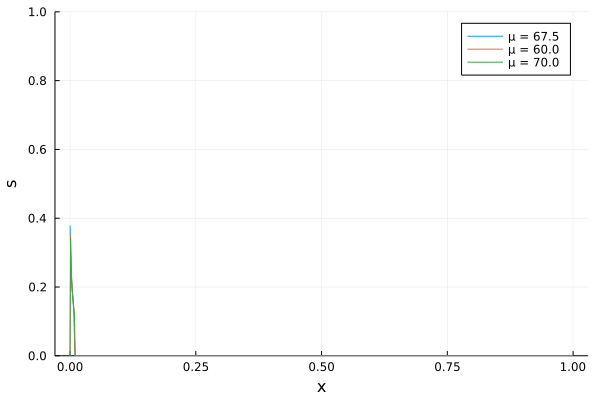

In [69]:
anim = @animate for i in eachindex(s_recon)
    plot(xgrid[1:end], [s_recon[i][1:end] S[:,i₋+i][1:end] S[:,i₊+i][1:end] ], ylims=(0, 1), xlabel="x", ylabel="s",
             legend=:topright, label=["μ = $mu_recon" "μ = $μ₋" "μ = $μ₊"])
end
gif(anim, "s_recon.gif", fps = 5)

#plot(xgrid, s_recon)

┌ Info: Saved animation to 
│   fn = /home/tobias/Documents/IPP/CIRM/MorporJ/notebooks/s_example.gif
└ @ Plots /home/tobias/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/home/tobias/Documents/IPP/CIRM/MorporJ/notebooks/s_example.gif")
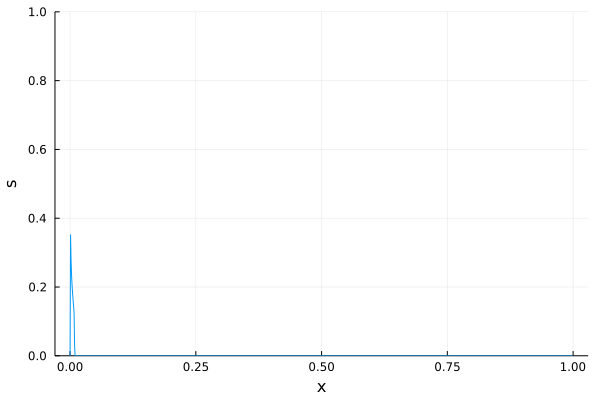

In [68]:
anim = @animate for i in eachindex(s_recon)
    plot(xgrid[1:end], S[:,i₋+i], ylims=(0, 1), xlabel="x", ylabel="s",
             legend=:none)
end
gif(anim, "s_example.gif", fps = 5)